In [22]:
import numpy as np
import scipy.io as sio
from scipy import ndimage
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
%config Completer.use_jedi = False
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

RESULT_LOCATION= "/home/adwaye/matlab_projects/test_CT/Figures"
PARAM_NAMES = ["L2_mean_grad","L2_bound_grad","L2_mean_pix","L2_bound_pix","noise","ndtct","agls","grdsz","alpha",
               "grad_quantile","pix_quantile"]


def extract_params_from_name(file_name):
    # expt_name = "curated_pe_xslice_225_BUQO_problem_result"
    # file_name = "curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.1_L2_bound_grad_0.8308_L2_mean_pix_0" \
    #             ".17773_L2_bound_pix_0.0001_noise_900_ndtct_900_agls_0.35282_grdsz.mat"
    """
    
    :param expt_name: 
    :param file_name: 
    :return: 
    """
    # param_names = ["L2_mean_grad","L2_bound_grad","L2_mean_pix","L2_bound_pix","noise","ndtct","agls","grdsz"]
    out_dict   = {}
    for name in PARAM_NAMES:
        ind = file_name.find(name)
        val = file_name[0:ind].split('_')[-2]
        #print(name+"="+val)
        out_dict[name] = val
    return out_dict



/home/adwaye/environments/odl/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  del sys.path[0]


In [2]:
def make_xmapFname_from_BUQOfname(file_name):
    path_split = file_name.split('/')
    if len(path_split)>0:
        file_name = path_split[-1]
    out_dict = extract_params_from_name(file_name)
    splits = file_name.split('_')
    ct_slice = splits[2]+'_'+splits[3]
    out_name = 'curated2_pe_'+ct_slice+'_forward_problem_results_'
    out_name = out_name +'{:}_noise_{:}_ndtct_{:}_agls_{:}_grdsz.mat'.format(out_dict['noise'],
                                                                             out_dict['ndtct'],
                                                                             out_dict['agls'],
                                                                             out_dict['grdsz'])
    
    return out_name
    
    
    
    

In [3]:


out_name = make_xmapFname_from_BUQOfname(file_name)
out_name

NameError: name 'file_name' is not defined

# Data Extraction
Extracting the experiments .mat files from  result into a pandas dataframe from the experiments folder into a dataframe

In [46]:
folder_name = "experiments_pnas"
print(folder_name)
root_folder = os.path.join("/home/adwaye/matlab_projects/test_CT/Figures",folder_name)


buqo_res_files = [os.path.join(root_folder,f) for f in os.listdir(root_folder) if f.split('.')[-1]=="mat" and "BUQO_problem_results" in f]


df = pd.DataFrame()
k = 0
rho_array = []
hpd_array = []
#boolean array that check for convergence of BUQO
M_conv_array = [] #bool if bound on M was satisfied
g_conv_array = [] #bool if bound on grad was satisfied
y_conv_array = [] #bool if bound on data fit y was satisfied
w_conv_array = [] #bool if bound on wave reg was satisfied
it_array     = [] #
map_it_array = []

for fname in buqo_res_files:
    fpath = fname
    print("------------------------------------------------------")
    print(fname.split('/')[-1])
    out_dict = extract_params_from_name(fname)
    out_name = make_xmapFname_from_BUQOfname(fname)
    print(out_name)
    
    df2 = pd.DataFrame()
    
    for keys, val in out_dict.items():
        if k == 0:
            df[keys] = np.array([val],dtype=str)
        else:
            df2[keys] = np.array([val],dtype=str)
    splits = fpath.split('/')[-1].split('_')
    ct_slice = splits[2]+'_'+splits[3]
    if k ==0:
        df['file_name'] = fpath#os.path.split(fname,'/')[-1]
        
        df['ct_slice']  = ct_slice
    else:
        df2['file_name'] = fpath#os.path.split(fname,'/')[-1]
        df2['ct_slice']  = ct_slice
        df = df.append(df2)
    k+=1
    matfile = sio.loadmat(fpath)
    rho_array +=[matfile['rho'].ravel()[0]]
    hpd_array += [matfile['hpd_constraint'].ravel()[0]]
    M_conv_array += [ matfile['l2smooth'].ravel()[-1]< matfile['l2_bound_pix'].ravel()[0] ] 
    g_conv_array += [ matfile['smooth_max'].ravel()[-1]< matfile['l2_bound_grad'].ravel()[0] ] 
    y_conv_array += [ matfile['l2data'].ravel()[-1]< matfile['epsilon'].ravel()[0] ] 
    w_conv_array += [ matfile['l1reg'].ravel()[-1]< matfile['hpd_constraint'].ravel()[0] ] 
    it_array     += [ matfile['l1reg'].shape[1]]
    map_it_array += [ ]
df['rho']  = np.array(rho_array)
df['hpd_constraint'] = hpd_array

df['agls'] = pd.to_numeric(df['agls'])
df['grad_quantile'] = pd.to_numeric(df['grad_quantile'])
df['rho'] = pd.to_numeric(df['rho'])
df['M_conv'] = M_conv_array
df['grad_conv'] = g_conv_array
df['data_conv'] = y_conv_array
df['hpd_conv']  = w_conv_array
df['BUQO_conv'] = np.array(M_conv_array)*np.array(g_conv_array)*np.array(y_conv_array)*np.array(w_conv_array)
df['iterations']= it_array
df.index = np.arange(0,df.shape[0])

experiments_pnas
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.019403_L2_bound_grad_0.7_grad_quantile_0.84403_L2_mean_pix_0.017032_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.01_noise_450_ndtct_50_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.01_noise_450_ndtct_50_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.048002_L2_bound_grad_0.9_grad_quantile_0.80715_L2_mean_pix_0.033084_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.25_noise_450_ndtct_300_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.25_noise_450_ndtct_300_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.034623_L2_bound_grad_0.9_grad_quantile_0.78735_L2_mean_pix_0.049874_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.125_noise_450_ndtct_50

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.034168_L2_bound_grad_0.9_grad_quantile_0.80826_L2_mean_pix_0.039461_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.05_noise_450_ndtct_450_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.05_noise_450_ndtct_450_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.011275_L2_bound_grad_0.7_grad_quantile_0.81273_L2_mean_pix_0.018399_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.01_noise_450_ndtct_450_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.01_noise_450_ndtct_450_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.025148_L2_bound_grad_0.9_grad_quantile_0.71325_L2_mean_pix_0.084711_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.175_noise_450_ndtct_25_agls_0.70564_g

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.012731_L2_bound_grad_0.7_grad_quantile_0.81929_L2_mean_pix_0.019524_L2_bound_pix_0.7_pix_quantile_0.01_alpha_5e-05_noise_450_ndtct_200_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_5e-05_noise_450_ndtct_200_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.017868_L2_bound_grad_0.7_grad_quantile_0.83299_L2_mean_pix_0.017601_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.15_noise_450_ndtct_450_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.15_noise_450_ndtct_450_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.041503_L2_bound_grad_0.9_grad_quantile_0.81263_L2_mean_pix_0.031374_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.125_noise_450_ndtct_200_agls_0.7056

------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.013423_L2_bound_grad_0.7_grad_quantile_0.83647_L2_mean_pix_0.012089_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.01_noise_450_ndtct_200_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.01_noise_450_ndtct_200_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.014333_L2_bound_grad_0.7_grad_quantile_0.79577_L2_mean_pix_0.018178_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.075_noise_450_ndtct_50_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.075_noise_450_ndtct_50_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0051479_L2_bound_grad_0.6_grad_quantile_0.81426_L2_mean_pix_0.013741_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.125_noise_450_ndtct_450_agls_0.70564

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.010944_L2_bound_grad_0.7_grad_quantile_0.81347_L2_mean_pix_0.018036_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.001_noise_450_ndtct_450_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.001_noise_450_ndtct_450_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.010906_L2_bound_grad_0.6_grad_quantile_0.82059_L2_mean_pix_0.0083765_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.25_noise_450_ndtct_50_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.25_noise_450_ndtct_50_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.034127_L2_bound_grad_0.9_grad_quantile_0.8137_L2_mean_pix_0.033486_L2_bound_pix_0.9_pix_quantile_0.01_alpha_5e-05_noise_450_ndtct_450_agls_0.70564_

------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.019051_L2_bound_grad_0.7_grad_quantile_0.8308_L2_mean_pix_0.017691_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.175_noise_450_ndtct_450_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.175_noise_450_ndtct_450_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.01291_L2_bound_grad_0.7_grad_quantile_0.81321_L2_mean_pix_0.017842_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.0003_noise_450_ndtct_300_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.0003_noise_450_ndtct_300_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0067473_L2_bound_grad_0.6_grad_quantile_0.81597_L2_mean_pix_0.010198_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.01_noise_450_ndtct_100_agls_0.70

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.016566_L2_bound_grad_0.7_grad_quantile_0.78745_L2_mean_pix_0.029428_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.15_noise_450_ndtct_50_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.15_noise_450_ndtct_50_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.011004_L2_bound_grad_0.7_grad_quantile_0.81426_L2_mean_pix_0.018531_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.125_noise_450_ndtct_450_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.125_noise_450_ndtct_450_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.01474_L2_bound_grad_0.7_grad_quantile_0.83644_L2_mean_pix_0.013861_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.01_noise_450_ndtct_300_agls_0.70564_gr

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0086878_L2_bound_grad_0.7_grad_quantile_0.71402_L2_mean_pix_0.021852_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.15_noise_450_ndtct_25_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.15_noise_450_ndtct_25_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.039306_L2_bound_grad_0.9_grad_quantile_0.78844_L2_mean_pix_0.040932_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.2_noise_450_ndtct_50_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.2_noise_450_ndtct_50_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.034793_L2_bound_grad_0.9_grad_quantile_0.81191_L2_mean_pix_0.032131_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.001_noise_450_ndtct_200_agls_0.70564_grdsz

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.013355_L2_bound_grad_0.7_grad_quantile_0.81132_L2_mean_pix_0.019503_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.2_noise_450_ndtct_300_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.2_noise_450_ndtct_300_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.02642_L2_bound_grad_0.9_grad_quantile_0.71335_L2_mean_pix_0.076671_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.25_noise_450_ndtct_25_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.25_noise_450_ndtct_25_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.047466_L2_bound_grad_0.9_grad_quantile_0.77673_L2_mean_pix_0.042358_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.5_noise_450_ndtct_200_agls_0.70564_grdsz.m

------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.043714_L2_bound_grad_0.9_grad_quantile_0.83532_L2_mean_pix_0.078572_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.1_noise_450_ndtct_50_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.1_noise_450_ndtct_50_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.055812_L2_bound_grad_0.9_grad_quantile_0.79047_L2_mean_pix_0.047194_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.5_noise_450_ndtct_100_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.5_noise_450_ndtct_100_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.0098029_L2_bound_grad_0.6_grad_quantile_0.8312_L2_mean_pix_0.0089952_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.125_noise_450_ndtct_300_agls_0.70564_grdsz

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.042074_L2_bound_grad_0.9_grad_quantile_0.80939_L2_mean_pix_0.035613_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.2_noise_450_ndtct_200_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.2_noise_450_ndtct_200_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.010487_L2_bound_grad_0.6_grad_quantile_0.82339_L2_mean_pix_0.010881_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.2_noise_450_ndtct_50_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.2_noise_450_ndtct_50_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.046798_L2_bound_grad_0.9_grad_quantile_0.83084_L2_mean_pix_0.074879_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.15_noise_450_ndtct_100_agls_0.70564_grdsz.m

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0045879_L2_bound_grad_0.6_grad_quantile_0.71402_L2_mean_pix_0.0072672_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.15_noise_450_ndtct_25_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.15_noise_450_ndtct_25_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.034402_L2_bound_grad_0.9_grad_quantile_0.81308_L2_mean_pix_0.032984_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.005_noise_450_ndtct_450_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.005_noise_450_ndtct_450_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.0093901_L2_bound_grad_0.6_grad_quantile_0.83519_L2_mean_pix_0.0080077_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.01_noise_450_ndtct_100_agls_0.705

------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.020358_L2_bound_grad_0.7_grad_quantile_0.83874_L2_mean_pix_0.020923_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.075_noise_450_ndtct_50_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.075_noise_450_ndtct_50_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.01296_L2_bound_grad_0.7_grad_quantile_0.80939_L2_mean_pix_0.019066_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.2_noise_450_ndtct_200_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.2_noise_450_ndtct_200_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.016976_L2_bound_grad_0.7_grad_quantile_0.83361_L2_mean_pix_0.01606_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.125_noise_450_ndtct_450_agls_0.70564_grds

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.035296_L2_bound_grad_0.9_grad_quantile_0.80959_L2_mean_pix_0.039203_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.01_noise_450_ndtct_200_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.01_noise_450_ndtct_200_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.009392_L2_bound_grad_0.6_grad_quantile_0.82829_L2_mean_pix_0.0096166_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.15_noise_450_ndtct_50_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.15_noise_450_ndtct_50_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0066182_L2_bound_grad_0.6_grad_quantile_0.8013_L2_mean_pix_0.0047566_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.005_noise_450_ndtct_50_agls_0.70564_g

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0079416_L2_bound_grad_0.6_grad_quantile_0.78808_L2_mean_pix_0.016752_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.5_noise_450_ndtct_300_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.5_noise_450_ndtct_300_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0060393_L2_bound_grad_0.6_grad_quantile_0.80715_L2_mean_pix_0.0070446_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.25_noise_450_ndtct_300_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.25_noise_450_ndtct_300_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.042676_L2_bound_grad_0.9_grad_quantile_0.81005_L2_mean_pix_0.037533_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.1_noise_450_ndtct_450_agls_0.70564_g

------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.042467_L2_bound_grad_0.9_grad_quantile_0.83361_L2_mean_pix_0.067937_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.125_noise_450_ndtct_450_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.125_noise_450_ndtct_450_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.017716_L2_bound_grad_0.7_grad_quantile_0.83084_L2_mean_pix_0.017871_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.15_noise_450_ndtct_100_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.15_noise_450_ndtct_100_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.017713_L2_bound_grad_0.7_grad_quantile_0.83144_L2_mean_pix_0.019404_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.15_noise_450_ndtct_200_agls_0.70564

------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0080283_L2_bound_grad_0.6_grad_quantile_0.78735_L2_mean_pix_0.01227_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.125_noise_450_ndtct_50_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.125_noise_450_ndtct_50_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.00566_L2_bound_grad_0.6_grad_quantile_0.81357_L2_mean_pix_0.0070932_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.0002_noise_450_ndtct_300_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.0002_noise_450_ndtct_300_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.012189_L2_bound_grad_0.7_grad_quantile_0.80942_L2_mean_pix_0.019902_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.2_noise_450_ndtct_450_agls_0.7056

------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.054914_L2_bound_grad_0.9_grad_quantile_0.79534_L2_mean_pix_0.089387_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.5_noise_450_ndtct_450_agls_0.70564_grdsz.mat
curated2_pe_xslice_225_forward_problem_results_0.5_noise_450_ndtct_450_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0067347_L2_bound_grad_0.6_grad_quantile_0.81346_L2_mean_pix_0.009378_L2_bound_pix_0.6_pix_quantile_0.01_alpha_0.0002_noise_450_ndtct_450_agls_0.70564_grdsz.mat
curated2_pe_yslice_266_forward_problem_results_0.0002_noise_450_ndtct_450_agls_0.70564_grdsz.mat
------------------------------------------------------
curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.045998_L2_bound_grad_0.9_grad_quantile_0.83868_L2_mean_pix_0.06373_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.05_noise_450_ndtct_300_agls_0.70564

In [3]:
out_dict


NameError: name 'out_dict' is not defined

# Data Filtering
Filtering the data so that only desirable angles and noise levels are present in the dataframe

In [47]:
df1 = df.copy()
columns = ['ndtct','noise','rho','agls','grad_quantile','pix_quantile','alpha']
for col in columns:
    df1[col]=pd.to_numeric(df1[col])

bool_loc = df1['ndtct']== 450

indexes = np.where(bool_loc)
# print(indexes)

df1 = df1.loc[indexes[0].tolist()].copy()
df1 = df1.sort_values(by='agls')
df2 = df1.copy()
df2 = df2.groupby('grad_quantile').get_group(0.6)
noise_list = [0.175,0.15,0.125,0.1,0.075,0.05,0.01]
df2 = df2[df2['noise'].isin(noise_list)]
angles_list = [50,100,200,300,450]
df2 = df2[df2['agls'].isin(angles_list)]
df2['iterations']

161      321
167    10001
321      350
305     4413
160     7151
       ...  
352     5591
342     5368
140      960
333      566
323     2739
Name: iterations, Length: 70, dtype: int64

In [6]:
#checking that the dataframe has the correct number of angles
df2_copy = df2.groupby("noise").get_group(0.15)
df2_copy = df2_copy.groupby("ct_slice").get_group("xslice_225")
df2_copy[['rho','agls','iterations']]


,rho,agls,iterations
321,2.520129e-14,50,350
20,2.484827e-14,100,440
309,2.469385e-14,200,506
149,2.456719e-14,300,532
183,2.436112e-14,450,556


In [12]:
#checking that the dataframe has the correct noise levels
df2_copy = df2.groupby("agls").get_group(300)
df2_copy = df2_copy.groupby("ct_slice").get_group("xslice_225")

n_colors= df2_copy['noise'].shape[0]

#df2_copy['noise'] = df2_copy['noise']/2
np.sort(df2_copy['noise'])

array([0.01 , 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175])

## Rho vs angles

,rho,agls,iterations,noise
305,3.153142e-01,50,4413,0.007071
227,5.052551e-02,50,10001,0.035355
167,4.017956e-03,50,10001,0.053033
8,1.297141e-05,50,10001,0.070711
161,2.547960e-14,50,321,0.123744
273,8.651689e-01,100,10001,0.007071
21,5.566281e-01,100,726,0.035355
226,3.656584e-01,100,614,0.053033
351,1.604100e-01,100,953,0.070711
387,2.520334e-14,100,10001,0.123744


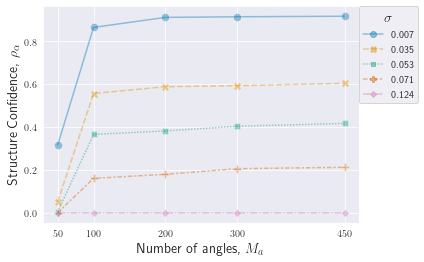

In [11]:
# df2_copy = df2.groupby("agls").get_group(50)
# df2_copy = df2_copy.groupby("ct_slice").get_group("xslice_225")
font_size = 14


df3 = df2.groupby('ct_slice')
slice_name = 'xslice_225'
df3 = df3.get_group(slice_name)
df3 = df3[df3.noise != 0.15]
df3 = df3[df3.noise != 0.125]
df3['noise'] = df3['noise']/np.sqrt(2)
n_colors= np.unique(df3['noise']).shape[0]

# marker = ['o', 'x', '^', '+', '*', '8', 's', 'p', 'D', 'V']
# # d = {'color': ['C0', 'k'], "ls" : ["-","--"]}
# # d = { "markers" : ['o', 'x', '^', '+', '*', '8', 's', 'p', 'D', 'V']}
d = { "ls" : [ 'dashdot', 'dashed', 'dotted', 'solid','dashdot', 'dashed', 'dotted', 'solid','dashdot', 'dashed', 'dotted', 'solid'],
      "markers" : ['o'  , 'x'     , '^'     , '+'    , '*'     , '8'     , 's'     , 'p'    , 'D'     , 'V'     ,'+'      , '*'     ]
    }
# markers = [marker[i] for i in range(len(df2["noise"].unique()))]
sns.set_style('darkgrid')
# grid = sns.FacetGrid(df2,col="ct_slice",hue="noise",hue_kws=d,#row='BUQO_conv',
#                          height=5,legend_out=True,palette=sns.color_palette("Paired")
#                     )
kwargs={'markersize':8}


fig, ax = plt.subplots()
g = sns.lineplot(ax=ax,data=df3,x="agls",y="rho",hue="noise",style="noise",markers=True,alpha=0.4,legend='auto',
                palette=sns.color_palette("colorblind", n_colors=n_colors),**kwargs)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# g.add_legend()
g.axes.set_xlabel("Noise")
# grid.axes[0,0].set_title("x slice 225")
g.axes.set_ylabel("Structure Confidence, $\\rho_{\\alpha}$",fontdict={'size':font_size})
g.axes.set_xlabel("Number of angles, $M_a$",fontdict={'size':font_size})
g.set_xticks([50,100,200,300,450])

# plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize='32')
# # grid.axes[0,1].set_title("y slice 225")
handles, lables = g.get_legend_handles_labels()
lables = ['{:.3f}'.format(float(f)) for f in lables]
for h in handles:
    h.set_alpha(0.4)
lgnd = plt.legend(handles, lables, bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0, title="$\\sigma$",title_fontsize=font_size)
plt.tight_layout()
fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# plt.suptitle('Rho vs number of measurements')

output_folder = "/home/adwaye/Documents/abstracts and papers/PNAS/figures"
plt.savefig(os.path.join(output_folder,slice_name+"_rho_vs_M.pdf"))
df3.sort_values(by=['agls','noise'])[['rho','agls','iterations','noise']]

In [34]:
np.unique(df3['noise'])

array([0.005 , 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875])

In [30]:
palette=sns.color_palette("colorblind", n_colors=n_colors)
palette.as_hex

<bound method _ColorPalette.as_hex of [(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0)]>

## log rho vs angle plot

/home/adwaye/environments/odl/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/adwaye/environments/odl/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


saved at /home/adwaye/Documents/abstracts and papers/PNAS/figures/xslice_225_logrho_vs_M.pdf


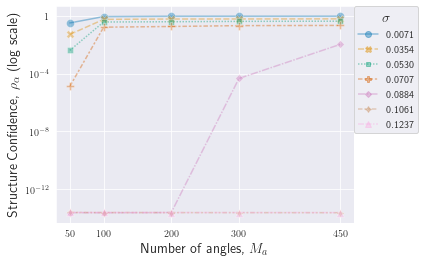

In [17]:
font_size = 14


df3 = df2.groupby('ct_slice')
slice_name = 'xslice_225'
df3 = df3.get_group(slice_name)
df3['log_rho'] = np.log10(df3['rho'])
df3['noise'] = df3['noise']/np.sqrt(2)
n_colors= np.unique(df3['noise']).shape[0]
# marker = ['o', 'x', '^', '+', '*', '8', 's', 'p', 'D', 'V']
# # d = {'color': ['C0', 'k'], "ls" : ["-","--"]}
# # d = { "markers" : ['o', 'x', '^', '+', '*', '8', 's', 'p', 'D', 'V']}
d = { "ls" : [ 'dashdot', 'dashed', 'dotted', 'solid','dashdot', 'dashed', 'dotted', 'solid','dashdot', 'dashed', 'dotted', 'solid'],
      "markers" : ['o'  , 'x'     , '^'     , '+'    , '*'     , '8'     , 's'     , 'p'    , 'D'     , 'V'     ,'+'      , '*'     ]
    }
# markers = [marker[i] for i in range(len(df2["noise"].unique()))]
sns.set_style('darkgrid')
# grid = sns.FacetGrid(df2,col="ct_slice",hue="noise",hue_kws=d,#row='BUQO_conv',
#                          height=5,legend_out=True,palette=sns.color_palette("Paired")
#                     )
kwargs={'markersize':8}


fig, ax = plt.subplots()
# ax.set(yscale='log')
g = sns.lineplot(ax=ax,data=df3,x="agls",y="log_rho",hue="noise",style="noise",markers=True,alpha=0.4,legend='auto',
                palette=sns.color_palette("colorblind", n_colors=n_colors),**kwargs)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# g.add_legend()
# grid.axes[0,0].set_title("x slice 225")
g.axes.set_ylabel("Structure Confidence, $\\rho_{\\alpha}$ (log scale)",fontdict={'size':font_size})
g.axes.set_xlabel("Number of angles, $M_a$",fontdict={'size':font_size})
g.set_xticks([50,100,200,300,450])
ax.set_yticks(ticks=[0,-4,-8,-12])#,
ax.set_yticklabels(labels=["$1$","$10^{-4}$","$10^{-8}$","$10^{-12}$"])


# plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize='32')
# # grid.axes[0,1].set_title("y slice 225")
handles, lables = g.get_legend_handles_labels()
lables = ['{:.4f}'.format(float(f)) for f in lables]
for h in handles:
    h.set_alpha(0.4)
lgnd = plt.legend(handles, lables, bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0, title="$\\sigma$",title_fontsize=font_size)
plt.tight_layout()
fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# plt.suptitle('Rho vs number of measurements')

output_folder = "/home/adwaye/Documents/abstracts and papers/PNAS/figures"
plt.savefig(os.path.join(output_folder,slice_name+"_logrho_vs_M.pdf"))
print('saved at '+os.path.join(output_folder,slice_name+"_logrho_vs_M.pdf"))

In [16]:
lables


['0.01', '0.05', '0.075', '0.1', '0.125', '0.15', '0.175']

## rho vs noise plot

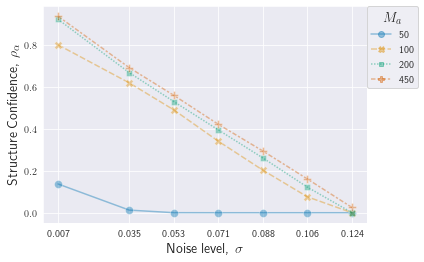

In [15]:
font_size = 14
slice_name = 'yslice_266'#'yslice_266'
df2_copy = df2.groupby("noise").get_group(0.175)
df2_copy = df2_copy.groupby("ct_slice").get_group(slice_name)



df3 = df2.groupby('ct_slice')

df3 = df3.get_group(slice_name)
df3 = df3[df3.agls != 300]
n_colors= np.unique(df3['agls']).shape[0]
df3['noise'] = df3['noise']/np.sqrt(2)

# marker = ['o', 'x', '^', '+', '*', '8', 's', 'p', 'D', 'V']
# # d = {'color': ['C0', 'k'], "ls" : ["-","--"]}
# # d = { "markers" : ['o', 'x', '^', '+', '*', '8', 's', 'p', 'D', 'V']}
d = { "ls" : [ 'dashdot', 'dashed', 'dotted', 'solid','dashdot', 'dashed', 'dotted', 'solid','dashdot', 'dashed', 'dotted', 'solid'],
      "markers" : ['o'  , 'x'     , '^'     , '+'    , '*'     , '8'     , 's'     , 'p'    , 'D'     , 'V'     ,'+'      , '*'     ]
    }
# markers = [marker[i] for i in range(len(df2["noise"].unique()))]
sns.set_style('darkgrid')
# grid = sns.FacetGrid(df2,col="ct_slice",hue="noise",hue_kws=d,#row='BUQO_conv',
#                          height=5,legend_out=True,palette=sns.color_palette("Paired")
#                     )
kwargs={'markersize':8}


fig, ax = plt.subplots()
g = sns.lineplot(ax=ax,data=df3,x="noise",y="rho",hue="agls",style="agls",markers=True,alpha=0.4,
                palette=sns.color_palette("colorblind", n_colors=n_colors),**kwargs)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# g.add_legend()
g.axes.set_xlabel("Noise")
# grid.axes[0,0].set_title("x slice 225")
g.axes.set_ylabel("Structure Confidence, $\\rho_{\\alpha}$",fontdict={'size':14})
g.axes.set_xlabel("Noise level, $\\sigma$",fontdict={'size':14})
g.set_xticks([0.01/np.sqrt(2),0.05/np.sqrt(2),0.075/np.sqrt(2),0.1/np.sqrt(2),0.125/np.sqrt(2),0.15/np.sqrt(2),0.175/np.sqrt(2)])
g.xaxis.set_major_formatter('{x:.3f}')
# grid.axes[0,1].set_title("y slice 225")

handles, lables = g.get_legend_handles_labels()
#lables = ['{:.4f}'.format(float(f)) for f in lables]
for h in handles:
    h.set_alpha(0.4)
lgnd = plt.legend(handles, lables, bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0, title='$M_a$',title_fontsize=font_size)
# g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
plt.tight_layout()
fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# plt.suptitle('Rho vs number of measurements')
output_folder = "/home/adwaye/Documents/abstracts and papers/PNAS/figures"
plt.savefig(os.path.join(output_folder,slice_name+"_rho_vs_noise.pdf"))

In [31]:
palette=sns.color_palette("colorblind", n_colors=n_colors)
palette.as_hex

<bound method _ColorPalette.as_hex of [(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0)]>

## log rho vs noise plot

/home/adwaye/environments/odl/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/adwaye/environments/odl/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


saved at /home/adwaye/Documents/abstracts and papers/PNAS/figures/yslice_266_logrho_vs_noise.pdf


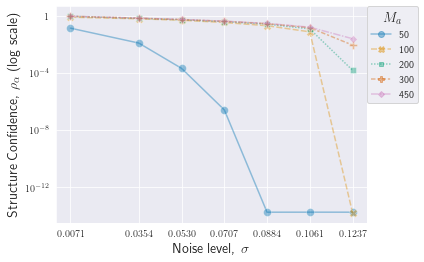

In [21]:
font_size = 14
slice_name = 'yslice_266'
df2_copy = df2.groupby("noise").get_group(0.175)
df2_copy = df2_copy.groupby("ct_slice").get_group(slice_name)

n_colors= df2_copy['agls'].shape[0]

df3 = df2.groupby('ct_slice')

df3 = df3.get_group(slice_name)
df3['log_rho'] = np.log10(df3['rho'])
df3['noise'] = df3['noise']/np.sqrt(2)
# marker = ['o', 'x', '^', '+', '*', '8', 's', 'p', 'D', 'V']
# # d = {'color': ['C0', 'k'], "ls" : ["-","--"]}
# # d = { "markers" : ['o', 'x', '^', '+', '*', '8', 's', 'p', 'D', 'V']}
d = { "ls" : [ 'dashdot', 'dashed', 'dotted', 'solid','dashdot', 'dashed', 'dotted', 'solid','dashdot', 'dashed', 'dotted', 'solid'],
      "markers" : ['o'  , 'x'     , '^'     , '+'    , '*'     , '8'     , 's'     , 'p'    , 'D'     , 'V'     ,'+'      , '*'     ]
    }
# markers = [marker[i] for i in range(len(df2["noise"].unique()))]
sns.set_style('darkgrid')
# grid = sns.FacetGrid(df2,col="ct_slice",hue="noise",hue_kws=d,#row='BUQO_conv',
#                          height=5,legend_out=True,palette=sns.color_palette("Paired")
#                     )
kwargs={'markersize':8}


fig, ax = plt.subplots()
g = sns.lineplot(ax=ax,data=df3,x="noise",y="log_rho",hue="agls",style="agls",markers=True,alpha=0.4,
                palette=sns.color_palette("colorblind", n_colors=n_colors),**kwargs)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# g.add_legend()

# grid.axes[0,0].set_title("x slice 225")
g.axes.set_ylabel("Structure Confidence, $\\rho_{\\alpha}$ (log scale)",fontdict={'size':font_size})
g.axes.set_xlabel("Noise level, $\\sigma$",fontdict={'size':font_size})
#g.set_xticks([0.01,0.05,0.075,0.1,0.125,0.15,0.175])
g.set_xticks([0.01/np.sqrt(2),0.05/np.sqrt(2),0.075/np.sqrt(2),0.1/np.sqrt(2),0.125/np.sqrt(2),0.15/np.sqrt(2),0.175/np.sqrt(2)])
ax.set_yticks(ticks=[0,-4,-8,-12])#,
ax.set_yticklabels(labels=["$1$","$10^{-4}$","$10^{-8}$","$10^{-12}$"])
# grid.axes[0,1].set_title("y slice 225")

handles, lables = g.get_legend_handles_labels()
for h in handles:
    h.set_alpha(0.4)
lgnd = plt.legend(handles, lables, bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0, title='$M_a$',title_fontsize=font_size)
# g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
plt.tight_layout()
fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# plt.suptitle('Rho vs number of measurements')
output_folder = "/home/adwaye/Documents/abstracts and papers/PNAS/figures"
plt.savefig(os.path.join(output_folder,slice_name+"_logrho_vs_noise.pdf"))
print('saved at '+os.path.join(output_folder,slice_name+"_logrho_vs_noise.pdf"))

## Qualitative plot
### Images vs angles (vertical)


Int64Index([0, 1, 2, 3, 4], dtype='int64')
50
450


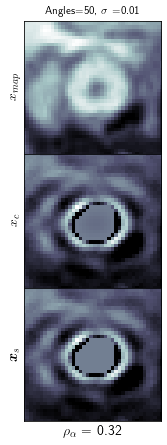

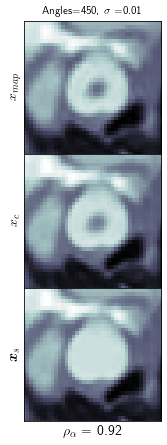

In [48]:

font_size = 14
df1.index = np.arange(0,df1.shape[0])
alpha = 0.01
grad_quantile = 0.6
pix_quantile  = 0.6
noise         = 0.01
ct_slice = 'xslice_225'#'xslice_225', 'yslice_266'


bool_loc = np.logical_and.reduce((df1['grad_quantile'] == grad_quantile ,
                                  df1['noise']== noise, 
                                  df1['alpha']==alpha,
                                  df1['ct_slice']==ct_slice))
indexes = np.where(bool_loc)



indexes[0].tolist()

# df1.loc[indexes[0].tolist()]
# df1['pix_quantile'].loc([])



k=0
df_copy = df1.loc[indexes[0].tolist()].copy()
df_copy = df_copy.sort_values(by='agls')
df_copy.index = np.arange(0,df_copy.shape[0])

print(df_copy.index)
k = 0



mask_struct = sio.loadmat(os.path.join(root_folder,buqo_res_files[0]))['struct_mask']
row_mask,col_mask = np.where(mask_struct>0)
max_x = np.max(row_mask)
min_x = np.min(row_mask)
max_y = np.max(col_mask)
min_y = np.min(col_mask)
upper_x = max_y+15;
lower_x =  min_y-15;
upper_y = max_x+15;
lower_y = min_x-15;

for n_angles in df_copy['agls']:
    
    if n_angles==25 or n_angles==100 or n_angles==300 or n_angles == 200:
        pass
    else:
        fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,7))
        print(n_angles)
        index = np.where(df_copy['agls']==n_angles)
        file_name = df_copy['file_name'].loc[index].ravel()[0]
        rho       = df_copy['rho'].loc[index].ravel()[0]
        matfile  = sio.loadmat(os.path.join(root_folder,file_name))
        ax[0].imshow(matfile['xmap'],cmap="bone")

    #     ax[k,0].set_title('xmap, noise={:}'.format(noise),fontsize=16)
    #     ax[k,0].set_title('xmap',fontsize=font_size)
    
        ax[0].axis([lower_x,upper_x,upper_y,lower_y])
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_ylabel('$x_{map}$',fontsize=font_size)
    #     ax[k,0].set(ylabel='Number of angles={:}'.format(n_angles,n_angles))
        ax[0].set_title('Angles={:}, $\\sigma$ ={:}'.format(n_angles,noise),fontsize=font_size-3)


        ax[1].imshow(matfile['x_c'],cmap="bone")
        ax[1].axis([lower_x,upper_x,upper_y,lower_y])
        ax[1].set_ylabel('$x_c$',fontsize=font_size)
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        ax[2].imshow(matfile['x_s'],cmap="bone")
        ax[2].axis([lower_x,upper_x,upper_y,lower_y])
        ax[2].set_ylabel('$\\boldsymbol{x}_s$',fontsize=font_size)
        ax[2].set_xlabel('$\\rho_\\alpha$ = {:.2}'.format(rho),fontsize=font_size)
        ax[2].set_xticks([])
        ax[2].set_yticks([])

        fig.subplots_adjust(top=0.92)
        plt.subplots_adjust(wspace=0, hspace=0)
        fig.savefig(os.path.join(output_folder,ct_slice+"_noise_{:}_angles_{:}.pdf".format(noise,n_angles)),bbox_inches='tight',transparent=True)

        k+=1

# fig.suptitle('Map estimate, image with structure and image without structure, noise={:}'.format(noise,alpha),fontsize=font_size)
    


# 
    
# plt.figure()
# sns.lineplot(data=df_copy,x='agls',y='rho')
# plt.show()

## Qualitative plot
### Images vs angles (horizontal)


Int64Index([0, 1, 2, 3, 4], dtype='int64')
50
saved at xslice_225_noise_0.01_angles_50_landscape.pdf
450
saved at xslice_225_noise_0.01_angles_450_landscape.pdf


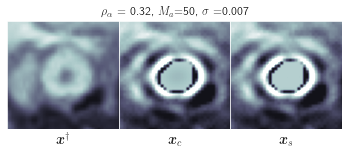

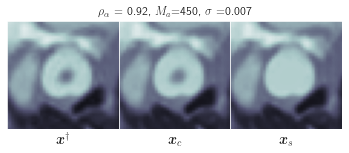

In [9]:

font_size = 14
df1.index = np.arange(0,df1.shape[0])
alpha = 0.01
grad_quantile = 0.6
pix_quantile  = 0.6
noise         = 0.01
ct_slice = 'xslice_225'#'xslice_225', 'yslice_266'


bool_loc = np.logical_and.reduce((df1['grad_quantile'] == grad_quantile ,
                                  df1['noise']== noise, 
                                  df1['alpha']==alpha,
                                  df1['ct_slice']==ct_slice))
indexes = np.where(bool_loc)



indexes[0].tolist()

# df1.loc[indexes[0].tolist()]
# df1['pix_quantile'].loc([])



k=0
df_copy = df1.loc[indexes[0].tolist()].copy()
df_copy = df_copy.sort_values(by='agls')
df_copy.index = np.arange(0,df_copy.shape[0])


print(df_copy.index)
k = 0



mask_struct = sio.loadmat(os.path.join(root_folder,buqo_res_files[0]))['struct_mask']
row_mask,col_mask = np.where(mask_struct>0)
max_x = np.max(row_mask)
min_x = np.min(row_mask)
max_y = np.max(col_mask)
min_y = np.min(col_mask)
upper_x = max_y+15;
lower_x =  min_y-15;
upper_y = max_x+15;
lower_y = min_x-15;

for n_angles in df_copy['agls']:
    
    if n_angles==25 or n_angles==100 or n_angles==300 or n_angles == 200:
        pass
    else:
        fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(6,3))
        print(n_angles)
        index = np.where(df_copy['agls']==n_angles)
        file_name = df_copy['file_name'].loc[index].ravel()[0]
        rho       = df_copy['rho'].loc[index].ravel()[0]
        matfile  = sio.loadmat(os.path.join(root_folder,file_name))
        ax[0].imshow(matfile['xmap'],cmap="bone",vmin=-0.1,vmax=1.1)

    #     ax[k,0].set_title('xmap, noise={:}'.format(noise),fontsize=16)
    #     ax[k,0].set_title('xmap',fontsize=font_size)
    
        ax[0].axis([lower_x,upper_x,upper_y,lower_y])
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_xlabel('$\\boldsymbol{x}^{\\dagger}$',fontsize=font_size)
    #     ax[k,0].set(ylabel='Number of angles={:}'.format(n_angles,n_angles))
        #ax[0].set_title('Angles={:}, $\\sigma$ ={:}'.format(n_angles,noise),fontsize=font_size-3)


        ax[1].imshow(matfile['x_c'],cmap="bone",vmin=-0.1,vmax=1.1)
        ax[1].axis([lower_x,upper_x,upper_y,lower_y])
        ax[1].set_xlabel('$\\boldsymbol{x}_c$',fontsize=font_size)
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        ax[2].imshow(matfile['x_s'],cmap="bone",vmin=-0.1,vmax=1.1)
        ax[2].axis([lower_x,upper_x,upper_y,lower_y])
        ax[2].set_xlabel('$\\boldsymbol{x}_s$',fontsize=font_size)
#         ax[2].set_xlabel('$\\rho_\\alpha$ = {:.2}'.format(rho),fontsize=font_size)
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[1].set_title('$\\rho_\\alpha$ = {:.2}, $M_a$={:}, $\\sigma$ ={:.3f}'.format(rho,n_angles,noise/np.sqrt(2),fontsize=font_size))

        fig.subplots_adjust(top=0.92)
        plt.subplots_adjust(wspace=0, hspace=0)
        fig.savefig(os.path.join(output_folder,ct_slice+"_noise_{:}_angles_{:}_landscape.pdf".format(noise,n_angles)),bbox_inches='tight',transparent=True)
        print("saved at "+ct_slice+"_noise_{:}_angles_{:}_landscape.pdf".format(noise,n_angles))

        k+=1

# fig.suptitle('Map estimate, image with structure and image without structure, noise={:}'.format(noise,alpha),fontsize=font_size)
    


# 
    
# plt.figure()
# sns.lineplot(data=df_copy,x='agls',y='rho')
# plt.show()

## Qualitative plot
### Images vs Noise (vertical)


Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
0.01
0.15


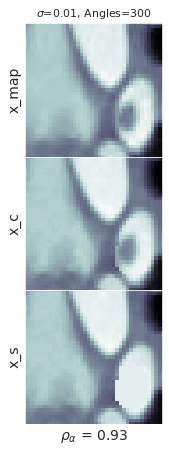

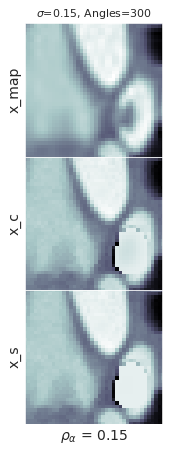

In [43]:

font_size = 14
df2.index = np.arange(0,df2.shape[0])
alpha = 0.01
grad_quantile = 0.6
pix_quantile  = 0.6
noise         = 0.01
angles        = 300
ct_slice = 'yslice_266'#'xslice_225', 'yslice_266'


bool_loc = np.logical_and.reduce((df2['grad_quantile'] == grad_quantile ,
                                  df2['agls']== angles, 
                                  df2['alpha']==alpha,
                                  df2['ct_slice']==ct_slice))
indexes = np.where(bool_loc)



indexes[0].tolist()

# df1.loc[indexes[0].tolist()]
# df1['pix_quantile'].loc([])



k=0
df_copy = df2.loc[indexes[0].tolist()].copy()
df_copy = df_copy.sort_values(by='noise')
df_copy.index = np.arange(0,df_copy.shape[0])

print(df_copy.index)
k = 0



mask_struct = sio.loadmat(os.path.join(root_folder,buqo_res_files[0]))['struct_mask']
row_mask,col_mask = np.where(mask_struct>0)
max_x = np.max(row_mask)
min_x = np.min(row_mask)
max_y = np.max(col_mask)
min_y = np.min(col_mask)
upper_x = max_y+15;
lower_x =  min_y-15;
upper_y = max_x+15;
lower_y = min_x-15;

for noise in df_copy['noise']:
    if noise==0.05 or noise==0.075 or noise==0.1 or noise==0.125 or noise==0.175 or noise==0.001  :
        pass
    else:
        fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,7))
        print(noise)
        index = np.where(df_copy['noise']==noise)
        file_name = df_copy['file_name'].loc[index].ravel()[0]
        rho       = df_copy['rho'].loc[index].ravel()[0]
        matfile  = sio.loadmat(os.path.join(root_folder,file_name))
        ax[0].imshow(matfile['xmap'],cmap="bone")

    #     ax[k,0].set_title('xmap, noise={:}'.format(noise),fontsize=16)
    #     ax[k,0].set_title('xmap',fontsize=font_size)
    
        ax[0].axis([lower_x,upper_x,upper_y,lower_y])
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_ylabel('x_map',fontsize=font_size)
    #     ax[k,0].set(ylabel='Number of angles={:}'.format(n_angles,n_angles))
        ax[0].set_title('$\\sigma$={:}, Angles={:}'.format(noise,angles),fontsize=font_size-3)


        ax[1].imshow(matfile['x_c'],cmap="bone")
        ax[1].axis([lower_x,upper_x,upper_y,lower_y])
        ax[1].set_ylabel('x_c',fontsize=font_size)
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        ax[2].imshow(matfile['x_s'],cmap="bone")
        ax[2].axis([lower_x,upper_x,upper_y,lower_y])
        ax[2].set_ylabel('x_s'.format(rho),fontsize=font_size)
        ax[2].set_xlabel('$\\rho_\\alpha$ = {:.2}'.format(rho),fontsize=font_size)
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        fig.subplots_adjust(top=0.92)
# fig.suptitle('Map estimate, image with structure and image without structure, noise={:}'.format(noise,alpha),fontsize=font_size)
    
        plt.subplots_adjust(wspace=0, hspace=0)
    
        fig.savefig(os.path.join(output_folder,ct_slice+"_angles_{:}_noise_{:.2}.pdf".format(angles,noise)),bbox_inches='tight',transparent=True)
        


        k+=1

    
# plt.figure()
# sns.lineplot(data=df_copy,x='agls',y='rho')
# plt.show()

## Qualitative plot
### Images vs noise (horizontal)


Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
0.01
saved at /home/adwaye/Documents/abstracts and papers/PNAS/figures/yslice_266_angles_450_noise_0.01_landscape.pdf
0.15
saved at /home/adwaye/Documents/abstracts and papers/PNAS/figures/yslice_266_angles_450_noise_0.15_landscape.pdf


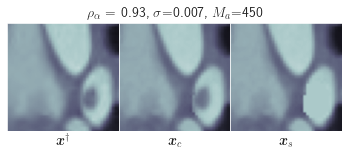

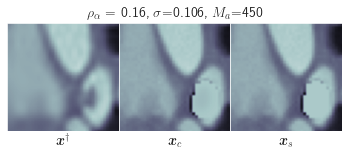

In [16]:

font_size = 14
df2.index = np.arange(0,df2.shape[0])
alpha = 0.01
grad_quantile = 0.6
pix_quantile  = 0.6
noise         = 0.01
angles        = 450
ct_slice = 'yslice_266'#'xslice_225', 'yslice_266'


bool_loc = np.logical_and.reduce((df2['grad_quantile'] == grad_quantile ,
                                  df2['agls']== angles, 
                                  df2['alpha']==alpha,
                                  df2['ct_slice']==ct_slice))
indexes = np.where(bool_loc)



indexes[0].tolist()

# df1.loc[indexes[0].tolist()]
# df1['pix_quantile'].loc([])



k=0
df_copy = df2.loc[indexes[0].tolist()].copy()
df_copy = df_copy.sort_values(by='noise')
df_copy.index = np.arange(0,df_copy.shape[0])

print(df_copy.index)
k = 0



mask_struct = sio.loadmat(os.path.join(root_folder,buqo_res_files[0]))['struct_mask']
row_mask,col_mask = np.where(mask_struct>0)
max_x = np.max(row_mask)
min_x = np.min(row_mask)
max_y = np.max(col_mask)
min_y = np.min(col_mask)
upper_x = max_y+15;
lower_x =  min_y-15;
upper_y = max_x+15;
lower_y = min_x-15;

for noise in df_copy['noise']:
    if noise==0.05 or noise==0.075 or noise==0.1 or noise==0.125 or noise==0.175 or noise==0.001  :
        pass
    else:
        fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(6,3))
        print(noise)
        index = np.where(df_copy['noise']==noise)
        file_name = df_copy['file_name'].loc[index].ravel()[0]
        rho       = df_copy['rho'].loc[index].ravel()[0]
        matfile  = sio.loadmat(os.path.join(root_folder,file_name))
        ax[0].imshow(matfile['xmap'],cmap="bone",vmin=-0.1,vmax=1.1)

    #     ax[k,0].set_title('xmap, noise={:}'.format(noise),fontsize=16)
    #     ax[k,0].set_title('xmap',fontsize=font_size)
    
        ax[0].axis([lower_x,upper_x,upper_y,lower_y])
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_xlabel('$\\boldsymbol{x}^{\\dagger}$',fontsize=font_size)
    #     ax[k,0].set(ylabel='Number of angles={:}'.format(n_angles,n_angles))
        #x[0].set_title('$\\sigma$={:}, Angles={:}'.format(noise,angles),fontsize=font_size-3)


        ax[1].imshow(matfile['x_c'],cmap="bone",vmin=-0.1,vmax=1.1)
        ax[1].axis([lower_x,upper_x,upper_y,lower_y])
        ax[1].set_xlabel('$\\boldsymbol{x}_c$',fontsize=font_size)
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        ax[2].imshow(matfile['x_s'],cmap="bone",vmin=-0.1,vmax=1.1)
        ax[2].axis([lower_x,upper_x,upper_y,lower_y])
        ax[2].set_xlabel('$\\boldsymbol{x}_s$',fontsize=font_size)
        
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[1].set_title('$\\rho_\\alpha$ = {:.2}, $\\sigma$={:.3f}, $M_a$={:}'.format(rho,noise/np.sqrt(2),angles),fontsize=font_size)
        fig.subplots_adjust(top=0.92)
        
        
# fig.suptitle('Map estimate, image with structure and image without structure, noise={:}'.format(noise,alpha),fontsize=font_size)
    
        plt.subplots_adjust(wspace=0, hspace=0)
    
        fig.savefig(os.path.join(output_folder,ct_slice+"_angles_{:}_noise_{:.2}_landscape.pdf".format(angles,noise)),bbox_inches='tight',transparent=True)
        print("saved at "+os.path.join(output_folder,ct_slice+"_angles_{:}_noise_{:.2}_landscape.pdf".format(angles,noise)))
        


        k+=1

    
# plt.figure()
# sns.lineplot(data=df_copy,x='agls',y='rho')
# plt.show()

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34],
           dtype='int64')


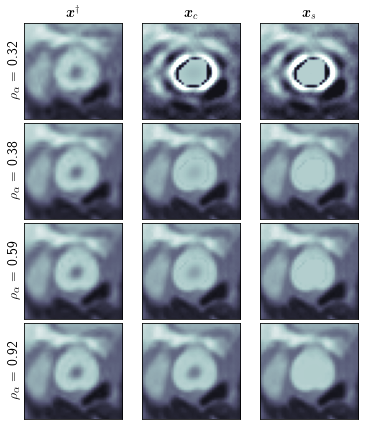

### Open cv draw outline test

(165.0, 204.0, 200.0, 162.0)

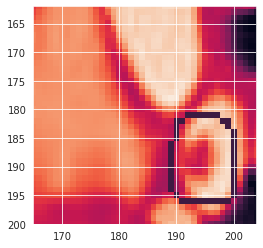

In [32]:
import cv2
image = cv2.UMat(matfile['xmap']*255)
mask = cv2.UMat(matfile['struct_mask'])
kernel = np.ones((5,5),np.uint8)
mask = cv2.dilate(mask,kernel)
tmp = cv2.UMat(np.zeros(matfile['struct_mask'].shape))
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (36, 255, 12), thickness=1)

plt.imshow( cv2.UMat.get(image))
plt.axis([lower_x,upper_x,upper_y,lower_y])


(165.0, 204.0, 200.0, 162.0)

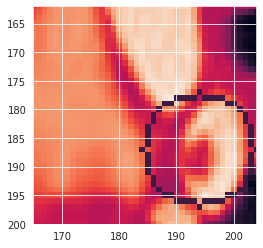

In [54]:
import cv2
image = cv2.UMat(matfile['xmap']*255)
mask = cv2.UMat(matfile['struct_mask'])
kernel = np.ones((5,5),np.uint8)
# mask = cv2.dilate(mask,kernel)
tmp = cv2.UMat(np.zeros(matfile['struct_mask'].shape))
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     cv2.drawContours(image, [c], -1, (36, 255, 12), thickness=1)
center = np.mean(cv2.UMat.get(cnts[0]),axis=0).astype(np.int)

cv2.circle(image,center=(center[0,0],center[0,1]),radius=10,color=(36, 255, 12), thickness=1)
plt.imshow( cv2.UMat.get(image))
plt.axis([lower_x,upper_x,upper_y,lower_y])


center[0]

Int64Index([0, 1, 2, 3, 4], dtype='int64')


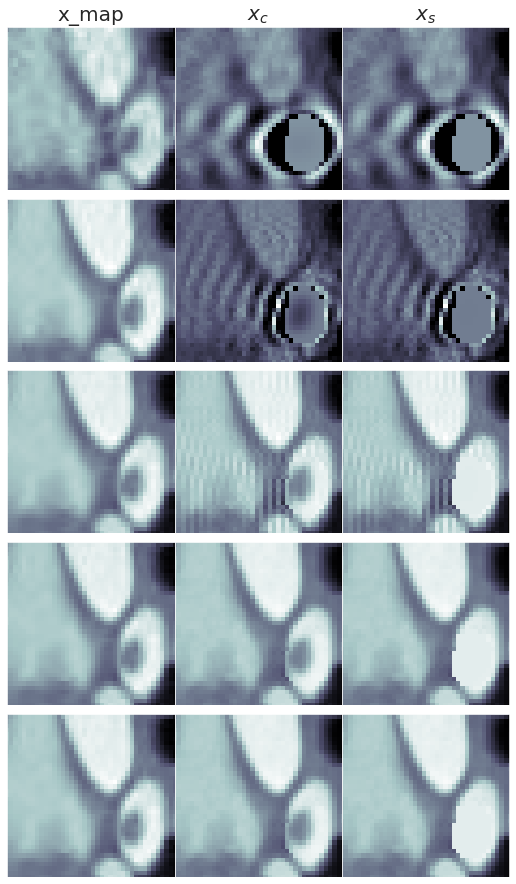

In [77]:

font_size = 20
df1.index = np.arange(0,df1.shape[0])
alpha = 0.01
grad_quantile = 0.6
pix_quantile  = 0.6
noise         = 0.01
ct_slice = 'yslice_266'#'xslice_225', 'yslice_266'


bool_loc = np.logical_and.reduce((df1['grad_quantile'] == grad_quantile ,
                                  df1['noise']== noise, 
                                  df1['alpha']==alpha,
                                  df1['ct_slice']==ct_slice))
indexes = np.where(bool_loc)



indexes[0].tolist()

# df1.loc[indexes[0].tolist()]
# df1['pix_quantile'].loc([])



k=0
df_copy = df1.loc[indexes[0].tolist()].copy()
df_copy = df_copy.sort_values(by='agls')
df_copy.index = np.arange(0,df_copy.shape[0])
fig, ax = plt.subplots(nrows=df_copy.shape[0],ncols=3,figsize=(9,15))
print(df_copy.index)
k = 0



mask_struct = sio.loadmat(os.path.join(root_folder,buqo_res_files[0]))['struct_mask']
row_mask,col_mask = np.where(mask_struct>0)
max_x = np.max(row_mask)
min_x = np.min(row_mask)
max_y = np.max(col_mask)
min_y = np.min(col_mask)
upper_x = max_y+15;
lower_x =  min_y-15;
upper_y = max_x+15;
lower_y = min_x-15;

for n_angles in df_copy['agls']:
    if n_angles==25:
        pass
    else:
        index = np.where(df_copy['agls']==n_angles)
        file_name = df_copy['file_name'].loc[index].ravel()[0]
        rho       = df_copy['rho'].loc[index].ravel()[0]
        matfile  = sio.loadmat(os.path.join(root_folder,file_name))
        ax[k,0].imshow(matfile['xmap'],cmap="bone")

    #     ax[k,0].set_title('xmap, noise={:}'.format(noise),fontsize=16)
    #     ax[k,0].set_title('xmap',fontsize=font_size)
        ax[k,0].axis([lower_x,upper_x,upper_y,lower_y])
        ax[k,0].set_xticks([])
        ax[k,0].set_yticks([])
    #     ax[k,0].set(ylabel='Number of angles={:}'.format(n_angles,n_angles))
    #     ax[k,0].set_ylabel('Angles={:}'.format(n_angles),fontsize=font_size-3)


        ax[k,1].imshow(matfile['x_c'],cmap="bone")
        ax[k,1].axis([lower_x,upper_x,upper_y,lower_y])
    #     ax[k,1].set_title('x_c',fontsize=font_size)
        ax[k,1].set_xticks([])
        ax[k,1].set_yticks([])

        ax[k,2].imshow(matfile['x_s'],cmap="bone")
        ax[k,2].axis([lower_x,upper_x,upper_y,lower_y])
    #     ax[k,2].set_title('x_s,rho={:.2}'.format(rho),fontsize=font_size)
        ax[k,2].set_xticks([])
        ax[k,2].set_yticks([])
        if k ==0:
            ax[k,0].set_title('x_map'.format(rho),fontsize=font_size)
            ax[k,1].set_title('$x_c$'.format(rho),fontsize=font_size)
            ax[k,2].set_title('$x_s$'.format(rho),fontsize=font_size)



        k+=1
fig.subplots_adjust(top=0.92)
# fig.suptitle('Map estimate, image with structure and image without structure, noise={:}'.format(noise,alpha),fontsize=font_size)
    
plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig(os.path.join(output_folder,ct_slice+"_noise_{:}.pdf".format(noise)),bbox_inches='tight')
    
# plt.figure()
# sns.lineplot(data=df_copy,x='agls',y='rho')
# plt.show()

In [ ]:
import nrrd
import scipy.io as sio
folder = "/home/adwaye/matlab_projects/test_CT/Data/ct_scans/ct1"

ct_name = "DE_CTPA_1_5_Bv38_2_F_0.mat"
label_name = "pe_DE_CTPA_1_5_Bv38_2_F_0.mat"
ct_matfile = sio.loadmat(os.path.join(folder,ct_name))
label_matfile = sio.loadmat(os.path.join(folder,label_name))
ct = ct_matfile['array']
label = label_matfile['array']

In [ ]:
import cv2
target_folder = "/home/adwaye/matlab_projects/test_CT/DataAspax_annot/"
slice_index = 266
fig,ax = plt.subplots(ncols=3,figsize=(30,10))
ax[0].imshow(ct[:,slice_index,:])
ax[1].imshow(label[:,slice_index,:])
im = ct[:,slice_index,:]
ct_scaled = im - np.min(im)
ct_scaled = ct_scaled/(np.max(im)-np.min(im))
ct_scaled *= 255
cv2.imwrite(os.path.join(target_folder,"pe_yslice_"+str(slice_index)+".png"),ct_scaled)

## Qualitative plot artefact testing landscape

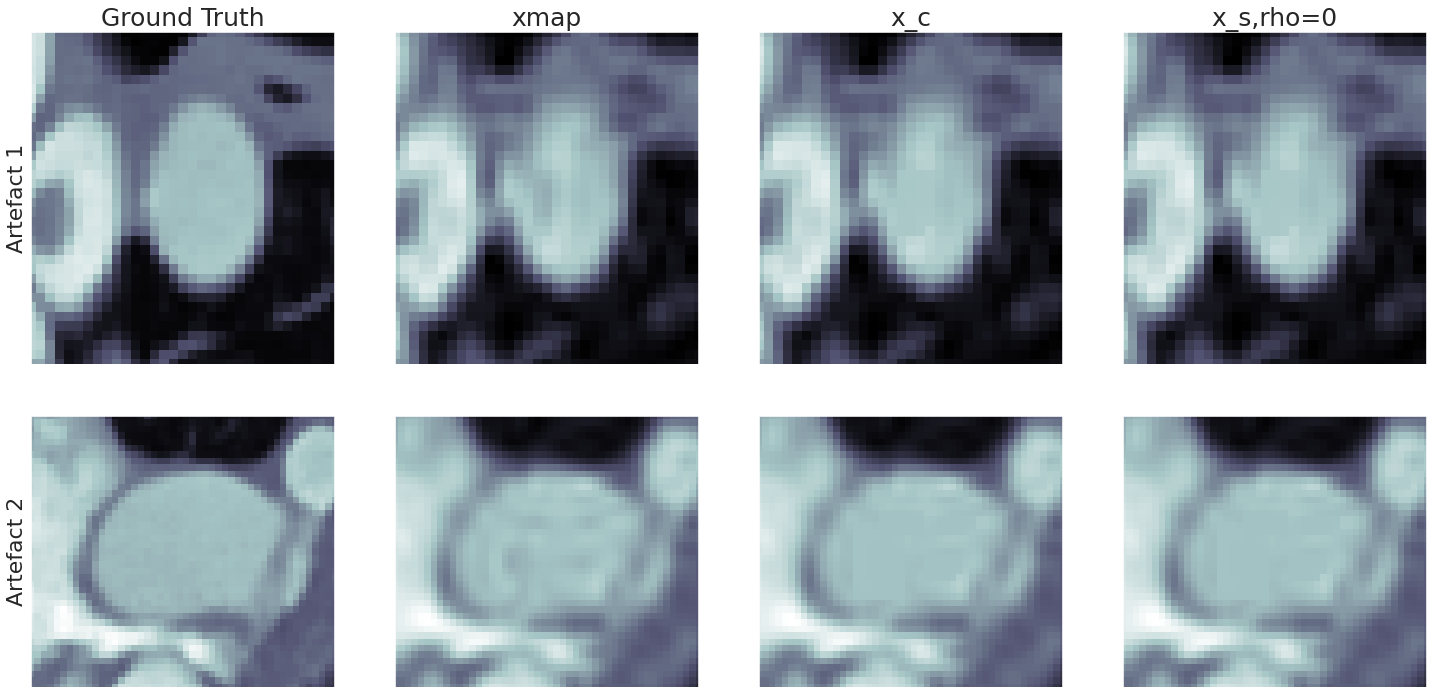

In [149]:

source_folder = "/home/adwaye/matlab_projects/test_CT/Figures/artefact_experiment_L2_gradM_L2_M"
font_size = 25
# df1.index = np.arange(0,df1.shape[0])
alpha = 0.01
grad_quantile = 0.6
pix_quantile  = 0.6
noise         = 0.00005
ct_slice = 'xslice_225'#'xslice_225', 'yslice_266'
output_folder = "/home/adwaye/Documents/abstracts and papers/PNAS/figures"

# artefact2 = "curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.012085_L2_bound_grad_0.9_grad_quantile_0.6844_L2_mean_pix_0.013819_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.0002_noise_450_ndtct_200_agls_0.70564_grdsz.mat"
# artefact1 = "curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.005985_L2_bound_grad_0.9_grad_quantile_0.70594_L2_mean_pix_0.016424_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.0002_noise_450_ndtct_200_agls_0.70564_grdsz.mat"


# artefact2 = 
# artefact1 = 

fnames = ["/home/adwaye/matlab_projects/test_CT/Data/curated2_pe_yslice_266.mat"
         ,"/home/adwaye/matlab_projects/test_CT/Data/curated2_pe_xslice_225.mat"
         ]

im_frame = []
scale_percent = 50
max_size = 350
for f in fnames:
    matfile  = sio.loadmat(f)
    im      = matfile['CT']
    im_name = f.split('/')[-1].split('.')[0]+'.png'
    imPath = os.path.join(output_folder,im_name)
    
    im_norm = im-np.min(im)
    im_norm = im_norm/(np.max(im)-np.min(im))

    width = int(im_norm.shape[1] * scale_percent / 100)
    height = int(im_norm.shape[0] * scale_percent / 100)
    dim = (width, height)
  
# resize image
    im_resized = cv2.resize(im_norm, dim, interpolation = cv2.INTER_AREA)
    
    pad_side   = (max_size-im_resized.shape[1])//2
    pad_up = (max_size-im_resized.shape[0])//2
    im_pad =  cv2.copyMakeBorder(im_resized, pad_up, pad_up, pad_side, pad_side,cv2.BORDER_CONSTANT )
    im_tosave = im_pad*255.
    cv2.imwrite(imPath,im_tosave)    
    im_frame +=[im_pad]
    
    


fnames = ["curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0099285_L2_bound_grad_0.7_grad_quantile_0.70323_L2_mean_pix_0.023557_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.175_noise_450_ndtct_50_agls_0.70564_grdsz.mat"
         ,"curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.0048351_L2_bound_grad_0.7_grad_quantile_0.70988_L2_mean_pix_0.01047_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.175_noise_450_ndtct_50_agls_0.70564_grdsz.mat"
          ]



# df1.loc[indexes[0].tolist()]
# df1['pix_quantile'].loc([])


fig, ax = plt.subplots(ncols=len(fnames),nrows=4,figsize=(25,13))
k =0
for fname in fnames:
    matfile = sio.loadmat(os.path.join(source_folder,fname))
    mask_struct = matfile['struct_mask']
    row_mask,col_mask = np.where(mask_struct>0)
    max_x = np.max(row_mask)
    min_x = np.min(row_mask)
    max_y = np.max(col_mask)
    min_y = np.min(col_mask)
    upper_x = max_y+15;
    lower_x =  min_y-15;
    upper_y = max_x+15;
    lower_y = min_x-15;


    rho       = matfile['rho'].ravel()[0]
    
    
        
    ax[k,0].imshow(im_frame[k],cmap="bone")
#     ax[k,0].set_title('xmap, noise={:}'.format(noise),fontsize=16)
    ax[k,0].axis([lower_x,upper_x,upper_y,lower_y])
    ax[k,0].set_xticks([])
    ax[k,0].set_yticks([])
#     ax[k,0].set(ylabel='Number of angles={:}'.format(n_angles,n_angles))
    ax[k,0].set_ylabel('Artefact {:}'.format(k+1),fontsize=font_size-3)
    
    
    ax[k,1].imshow(matfile['xmap'],cmap="bone")
#     ax[k,0].set_title('xmap, noise={:}'.format(noise),fontsize=16)
    ax[k,1].axis([lower_x,upper_x,upper_y,lower_y])
    ax[k,1].set_xticks([])
    ax[k,1].set_yticks([])
#     ax[k,0].set(ylabel='Number of angles={:}'.format(n_angles,n_angles))
#     ax[k,0].set_ylabel('Artefact {:}'.format(k+1),fontsize=font_size-3)
    ax[k,2].imshow(matfile['x_c'],cmap="bone")
    ax[k,2].axis([lower_x,upper_x,upper_y,lower_y])
    ax[k,2].set_xticks([])
    ax[k,2].set_yticks([])
    
    ax[k,3].imshow(matfile['x_s'],cmap="bone")
    ax[k,3].axis([lower_x,upper_x,upper_y,lower_y])
    ax[k,3].set_xticks([])
    ax[k,3].set_yticks([])
    if k==0:
        ax[k,3].set_title('x_s,rho={:}'.format(rho),fontsize=font_size)
        ax[k,2].set_title('x_c',fontsize=font_size)
        ax[k,1].set_title('xmap',fontsize=font_size)
        ax[k,0].set_title('Ground Truth',fontsize=font_size)
        
    
    k+=1
# fig.subplots_adjust(top=0.9)
# fig.suptitle('Map estimate, image with structure and image without structure, noise={:}'.format(noise,alpha),fontsize=font_size)
    

# fig.subplots_adjust(top=0.95)
# fig.suptitle('Map estimate, image with structure and image without structure, noise={:}'.format(noise,alpha),fontsize=font_size)
    
plt.subplots_adjust( hspace=0)
fig.savefig(os.path.join(output_folder,"artefacts_detect.pdf"),bbox_inches='tight')
    
# plt.figure()
# sns.lineplot(data=df_copy,x='agls',y='rho')
# plt.show()

## Qualitative plot artefact testing

## Qualitative plot artefact testing
This one shows $\| \boldsymbol{x}_s-\boldsymbol{x}_c \|$ instead of $\boldsymbol{x}_s$

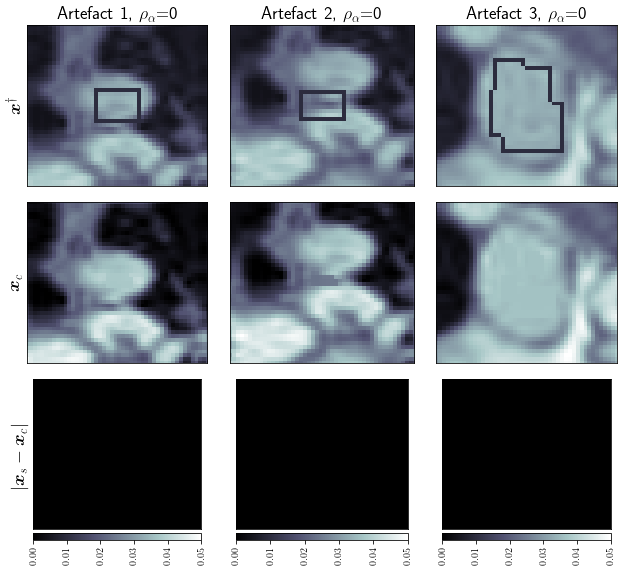

In [74]:

source_folder = "/home/adwaye/matlab_projects/test_CT/Figures/artefact_experiment_L2_gradM_L2_M"
font_size = 18
# df1.index = np.arange(0,df1.shape[0])
alpha = 0.01
grad_quantile = 0.6
pix_quantile  = 0.6
noise         = 0.00005
ct_slice = 'xslice_225'#'xslice_225', 'yslice_266'
output_folder = "/home/adwaye/Documents/abstracts and papers/PNAS/figures"

# artefact2 = "curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.012085_L2_bound_grad_0.9_grad_quantile_0.6844_L2_mean_pix_0.013819_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.0002_noise_450_ndtct_200_agls_0.70564_grdsz.mat"
# artefact1 = "curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.005985_L2_bound_grad_0.9_grad_quantile_0.70594_L2_mean_pix_0.016424_L2_bound_pix_0.9_pix_quantile_0.01_alpha_0.0002_noise_450_ndtct_200_agls_0.70564_grdsz.mat"


# artefact2 = 
# artefact1 = 

fnames = ["/home/adwaye/matlab_projects/test_CT/Data/curated2_pe_yslice_266.mat"
          ,"/home/adwaye/matlab_projects/test_CT/Data/curated2_pe_yslice_266.mat"
         ,"/home/adwaye/matlab_projects/test_CT/Data/curated2_pe_xslice_225.mat"
         ]

im_frame = []
scale_percent = 50
max_size = 350
for f in fnames:
    matfile  = sio.loadmat(f)
    im      = matfile['CT']
    im_name = f.split('/')[-1].split('.')[0]+'.png'
    imPath = os.path.join(output_folder,im_name)
    
    im_norm = im-np.min(im)
    im_norm = im_norm/(np.max(im)-np.min(im))

    width = int(im_norm.shape[1] * scale_percent / 100)
    height = int(im_norm.shape[0] * scale_percent / 100)
    dim = (width, height)
  
# resize image
    im_resized = cv2.resize(im_norm, dim, interpolation = cv2.INTER_AREA)
    
    pad_side   = (max_size-im_resized.shape[1])//2
    pad_up = (max_size-im_resized.shape[0])//2
    im_pad =  cv2.copyMakeBorder(im_resized, pad_up, pad_up, pad_side, pad_side,cv2.BORDER_CONSTANT )
    im_tosave = im_pad*255.
    cv2.imwrite(imPath,im_tosave)    
    im_frame +=[im_pad]
    
    


fnames = ["curated2_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.0099285_L2_bound_grad_0.7_grad_quantile_0.70323_L2_mean_pix_0.023557_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.175_noise_450_ndtct_50_agls_0.70564_grdsz.mat"
         ,"curated3_pe_yslice_266_BUQO_problem_results_0_L2_mean_grad_0.02102_L2_bound_grad_0.7_grad_quantile_0.4502_L2_mean_pix_0.023327_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.175_noise_450_ndtct_50_agls_0.70564_grdsz.mat"
         ,"curated2_pe_xslice_225_BUQO_problem_results_0_L2_mean_grad_0.0048351_L2_bound_grad_0.7_grad_quantile_0.70988_L2_mean_pix_0.01047_L2_bound_pix_0.7_pix_quantile_0.01_alpha_0.175_noise_450_ndtct_50_agls_0.70564_grdsz.mat"
          
          ]

noise_array = [0.175,0.175,0.175]
angles_array = [50,50,50]

# df1.loc[indexes[0].tolist()]
# df1['pix_quantile'].loc([])


fig, ax = plt.subplots(ncols=len(fnames),nrows=3,figsize=(11,9))
k =0


size_y = []
size_x = []
for fname in fnames:
    matfile = sio.loadmat(os.path.join(source_folder,fname))
    mask_struct = ndimage.rotate(matfile['struct_mask'],90)
    row_mask,col_mask = np.where(mask_struct>0)
    max_x = np.max(row_mask)
    min_x = np.min(row_mask)
    max_y = np.max(col_mask)
    min_y = np.min(col_mask)
    upper_x = max_y+15;
    lower_x =  min_y-15;
    size_y += [upper_x-lower_x]
    upper_y = max_x+15;
    lower_y = min_x-15;
    size_x += [upper_y-lower_y]

max_size_y = max(size_y)
max_size_x = max(size_x)  

    

for fname in fnames:
    
    matfile = sio.loadmat(os.path.join(source_folder,fname))
    mask_struct = ndimage.rotate(matfile['struct_mask'],90)
    row_mask,col_mask = np.where(mask_struct>0)
    max_x = np.max(row_mask)
    min_x = np.min(row_mask)
    max_y = np.max(col_mask)
    min_y = np.min(col_mask)
    upper_x = max_y+(max_size_x-(max_y-min_y))//2;
    lower_x =  min_y-(max_size_x-(max_y-min_y))//2;
    upper_y = max_x+(max_size_y-(max_x-min_x))//2;
    lower_y = min_x-(max_size_y-(max_x-min_x))//2;


    rho       = matfile['rho'].ravel()[0]
    
    
        
#     ax[0,k].imshow(im_frame[k],cmap="bone",vmin=-0.1,vmax=1.1)
# #     ax[k,0].set_title('xmap, noise={:}'.format(noise),fontsize=16)
#     ax[0,k].axis([lower_x,upper_x,upper_y,lower_y])
#     ax[0,k].set_xticks([])
#     ax[0,k].set_yticks([])
# #     ax[k,0].set(ylabel='Number of angles={:}'.format(n_angles,n_angles))
    ax[0,k].set_title('Artefact {:}, $\\rho_\\alpha$={:}'.format(k+1,rho),fontsize=font_size)
    
    im_temp = matfile['xmap']
    im_max  = np.max(im_temp)
    im_min  = np.min(im_temp)
    image = cv2.UMat(matfile['xmap']*255)
    mask = cv2.UMat(matfile['struct_mask'])
    kernel = np.ones((7,7),np.uint8)
    mask = cv2.dilate(mask,kernel)
    tmp = cv2.UMat(np.zeros(matfile['struct_mask'].shape))
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(image, [c], -1, (36, 255, 12), thickness=1)
    xmap = cv2.UMat.get(image)
    #xmap = ((xmap-np.min(xmap))/(np.max(xmap)-np.min(xmap))*
    ax[0,k].imshow(ndimage.rotate(cv2.UMat.get(image)/255,90),cmap="bone",vmin=-0.1,vmax=1.1)
#     ax[k,0].set_title('xmap, noise={:}'.format(noise),fontsize=16)
    ax[0,k].axis([lower_x,upper_x,upper_y,lower_y])
    ax[0,k].set_xticks([])
    ax[0,k].set_yticks([])
#     ax[k,0].set(ylabel='Number of angles={:}'.format(n_angles,n_angles))
#     ax[k,0].set_ylabel('Artefact {:}'.format(k+1),fontsize=font_size-3)
    ax[1,k].imshow(ndimage.rotate(matfile['x_c'],90),cmap="bone")
    ax[1,k].axis([lower_x,upper_x,upper_y,lower_y])
    ax[1,k].set_xticks([])
    ax[1,k].set_yticks([])
    
    im = ax[2,k].imshow(ndimage.rotate(np.abs(matfile['x_s']-matfile['x_c']),90),cmap="bone",vmin=0.0,vmax=0.05)
    ax[2,k].axis([lower_x,upper_x,upper_y,lower_y])
    ax[2,k].set_xticks([])
    ax[2,k].set_yticks([])
    #ax[2,k].set_xlabel('$\sigma$={:},$M_a$={:}'.format(noise_array[k],angles_array[k]),fontsize=font_size)
    divider = make_axes_locatable(ax[2,k])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)



    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(rotation=90)
    if k ==0: 
        ax[2,k].set_ylabel('$|\\boldsymbol{x}_s-\\boldsymbol{x}_c|$',fontsize=font_size)
        
        ax[1,k].set_ylabel('$\\boldsymbol{x}_c$',fontsize=font_size)
        ax[0,k].set_ylabel('$\\boldsymbol{x}^{\\dagger}$',fontsize=font_size)
        
    cv2.imwrite(os.path.join(output_folder,'xmap_{:}.png').format(k),matfile['xmap']*255)
    cv2.imwrite(os.path.join(output_folder,'g_truth_{:}.png').format(k),im_frame[k]*255)
    
    

    
    k+=1
# fig.subplots_adjust(top=0.9)
# fig.suptitle('Map estimate, image with structure and image without structure, noise={:}'.format(noise,alpha),fontsize=font_size)
    

fig.subplots_adjust(top=0.92)
# fig.suptitle('Map estimate, image with structure and image without structure, noise={:}'.format(noise,alpha),fontsize=font_size)
    
plt.subplots_adjust( hspace=0.1,wspace=0)
fig.savefig(os.path.join(output_folder,"artefacts_detect_diff.pdf"),bbox_inches='tight')
    
# plt.figure()
# sns.lineplot(data=df_copy,x='agls',y='rho')
# plt.show()

214

## Qualitative plot
### Images vs $\rho_{\alpha}$ (horizontal)


Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34],
           dtype='int64')


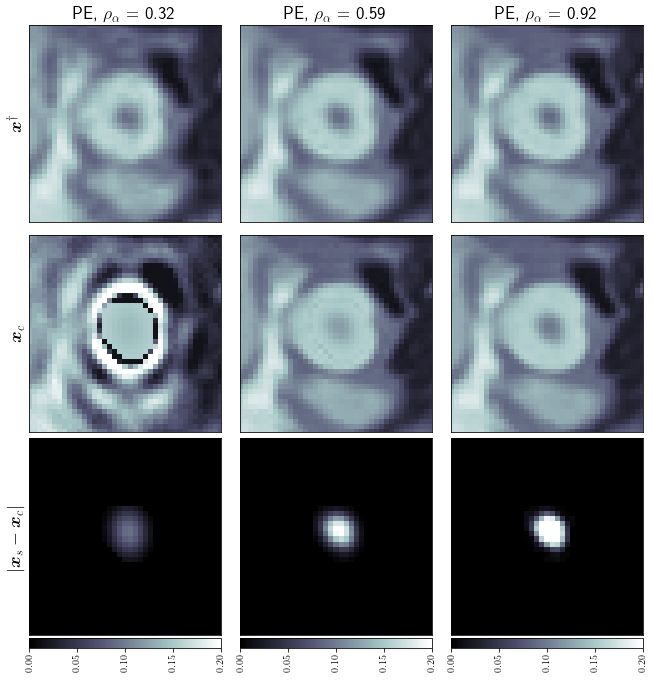

In [73]:

font_size = 18
df2.index = np.arange(0,df2.shape[0])
alpha = 0.01
grad_quantile = 0.6
pix_quantile  = 0.6
noise         = 0.01
#angles        = 300
ct_slice = 'xslice_225'#'xslice_225', 'yslice_266'

bool_loc = np.logical_and.reduce((df2['grad_quantile'] == grad_quantile ,
 #                                 df2['agls']== angles, 
                                  df2['alpha']==alpha,
                                  df2['ct_slice']==ct_slice))

indexes = np.where(bool_loc)



indexes[0].tolist()

k=0
df_copy = df2.loc[indexes[0].tolist()].copy()
df_copy = df_copy.sort_values(by='noise')
df_copy.index = np.arange(0,df_copy.shape[0])

print(df_copy.index)
k = 0



mask_struct = ndimage.rotate(sio.loadmat(os.path.join(root_folder,buqo_res_files[0]))['struct_mask'],90)
row_mask,col_mask = np.where(mask_struct>0)
max_x = np.max(row_mask)
min_x = np.min(row_mask)
max_y = np.max(col_mask)
min_y = np.min(col_mask)
upper_x = max_y+15;
lower_x =  min_y-15;
upper_y = max_x+15;
lower_y = min_x-15;


detector_setup = {'angles': [50  ,200  ,450 ],
                  'noise' : [0.01,0.05,0.01]
                 }
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(11,11))
for k in range(3):
    bool_loc = np.logical_and.reduce((df_copy['agls'] == detector_setup['angles'][k], 
                                      df_copy['noise']== detector_setup['noise'][k]))
    index = np.where(bool_loc)
    df_copy_copy = df_copy.loc[index[0].tolist()].copy()
    #print(df_copy_copy)
    file_name = df_copy['file_name'].loc[index].ravel()[0]
    rho       = df_copy['rho'].loc[index].ravel()[0]
    matfile  = sio.loadmat(os.path.join(root_folder,file_name))
    
    ax[0,k].imshow(ndimage.rotate(matfile['xmap'],90),cmap="bone",vmin=-0.1,vmax=1.1)
    ax[0,k].axis([lower_x,upper_x,upper_y,lower_y])
    ax[0,k].set_xticks([])
    ax[0,k].set_yticks([])
    ax[0,k].set_title(f'PE, $\\rho_\\alpha$ = {rho:.2f}',fontsize=font_size)
    #ax[0,k].set_ylabel(''.format(rho),fontsize=font_size)
    
    #ax[0].set_xlabel('$\\boldsymbol{x}^{\\dagger}$',fontsize=font_size)
    ax[1,k].imshow(ndimage.rotate(matfile['x_c'],90),cmap="bone",vmin=-0.1,vmax=1.1)
    ax[1,k].axis([lower_x,upper_x,upper_y,lower_y])
    
    #ax[k,1].set_xlabel('$\\boldsymbol{x}_c$',fontsize=font_size)
    ax[1,k].set_xticks([])
    ax[1,k].set_yticks([])

    im = ax[2,k].imshow(ndimage.rotate(np.abs(matfile['x_s']-matfile['x_c']),90),cmap="bone",vmin=0.0,vmax=0.2)
    ax[2,k].axis([lower_x,upper_x,upper_y,lower_y])
    ax[2,k].set_xticks([])
    ax[2,k].set_yticks([])
    #ax[2,k].set_xlabel('$\sigma$={:},$M_a$={:}'.format(noise_array[k],angles_array[k]),fontsize=font_size)
    divider = make_axes_locatable(ax[2,k])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    


    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(rotation=90)
    #ax[k,1].set_title('$\\rho_\\alpha$ = {:.2}, $\\sigma$={:}, $M_a$={:}'.format(rho,noise,angles),fontsize=font_size)
    if k==0:
        ax[2,k].set_ylabel('$|\\boldsymbol{x}_s-\\boldsymbol{x}_c|$',fontsize=font_size)
        
        ax[1,k].set_ylabel('$\\boldsymbol{x}_c$',fontsize=font_size)
        ax[0,k].set_ylabel('$\\boldsymbol{x}^{\\dagger}$',fontsize=font_size)
        
        #ax[0,k].set_title('$\\boldsymbol{x}^{\\dagger}$',fontsize=font_size)
#         ax[1,k].set_title('$\\boldsymbol{x}_{c}$',fontsize=font_size)
#         ax[2,k].set_title('$\\boldsymbol{x}_{s}$',fontsize=font_size)
    fig.subplots_adjust(top=0.92)
    #print(file_name)
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.savefig(os.path.join(output_folder,ct_slice+"_qualitative_rho.pdf"),bbox_inches='tight',transparent=True)
    
    
    

In [45]:
df2

,L2_mean_grad,L2_bound_grad,L2_mean_pix,L2_bound_pix,noise,ndtct,agls,grdsz,alpha,grad_quantile,pix_quantile,file_name,ct_slice
0,0,0.045998,0.83868,0.06373,0.05,450,300,0.70564,0.01,0.9,0.9,/home/adwaye/matlab_projects/test_CT/Figures/e...,xslice_225


# Complexity histogram
## Split by angles

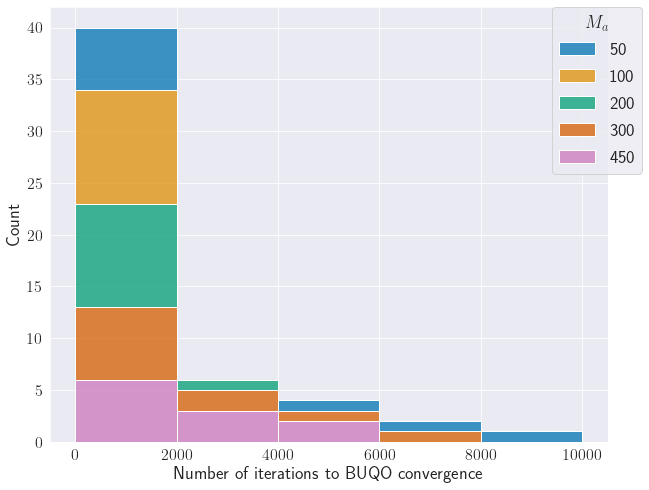

In [83]:
import itertools
font_size = 18
n_colors = 5
fig,ax = plt.subplots(figsize=(10,8))
g = sns.histplot(df2,ax=ax,x='iterations',hue='agls',palette=sns.color_palette("colorblind", n_colors=n_colors),multiple="stack",bins=[0,2000,4000,6000,8000,10000])
num_locations = 5
hatches = itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'])
# for i, bar in enumerate(ax.patches):
#     if i % num_locations == 0:
#         hatch = next(hatches)
#     bar.set_hatch(hatch)
ax.set_xlabel('Number of iterations to BUQO convergence',fontsize=font_size)
ax.set_ylabel('Count',fontsize=font_size)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

num_locations = 5
hatches = itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'])

# for i, bar in enumerate(ax.patches):
#     print(i)
#     if i % (num_locations-1) == 0:

#         hatch = next(hatches)
#     bar.set_hatch(hatch)

# #hatches.r
# g.legend(handles=)
# g.legend_.set_title(title='Angles')
# g.legend_.legendHandles

# labels=[]
# for text in g.legend_.get_texts():
#     labels+=[text.get_text()]
# for p,hatch in zip(g.legend_.legendHandles,hatches):
#     p.set_hatch(hatch)
lgnd = plt.legend(g.legend_.legendHandles, labels, bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0, title='$M_a$',title_fontsize=font_size,fontsize=font_size)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fancybox=True)
output_folder = "/home/adwaye/Documents/abstracts and papers/PNAS/figures"
plt.savefig(os.path.join(output_folder,"complexity_histogram_agls.pdf"))

8

# Complexity histogram
## Split by angles

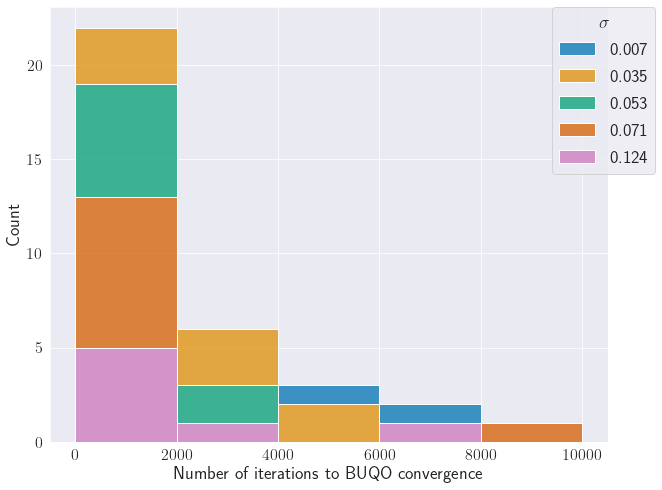

In [84]:
import itertools
df3 = df2.copy()
df3 = df3[df3.noise != 0.15]
df3 = df3[df3.noise != 0.125]
df3['noise'] = df3['noise']/np.sqrt(2)
n_colors= np.unique(df3['noise']).shape[0]
font_size = 18

fig,ax = plt.subplots(figsize=(10,8))
g = sns.histplot(df3,ax=ax,x='iterations',hue='noise',palette=sns.color_palette("colorblind", n_colors=n_colors),multiple="stack",bins=[0,2000,4000,6000,8000,10000],legend='auto')
num_locations = 5
hatches = itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'])
# for i, bar in enumerate(ax.patches):
#     if i % num_locations == 0:
#         hatch = next(hatches)
#     bar.set_hatch(hatch)
ax.set_xlabel('Number of iterations to BUQO convergence',fontsize=font_size)
ax.set_ylabel('Count',fontsize=font_size)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# for h in handles:
#     h.set_alpha(0.4)

# 
#plt.legend(loc="upper right", frameon=True, fontsize=font_size)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fancybox=True)
#g.legend_.set_title(title='Angles')
#g.legend_.legendHandles
legend = g.get_legend()
handles = legend.legendHandles

labels = [f.get_text() for f in legend.texts]

# handles, lables = g.get_legend_handles_labels()
labels = ['{:.3f}'.format(float(f)) for f in labels]
# for h in handles:
#     h.set_alpha(0.4)
lgnd = plt.legend(handles, labels, bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0, title="$\\sigma$",title_fontsize=font_size,fontsize=font_size)
#lgnd = plt.legend(g.legend_.legendHandles, labels, bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0, title='$M_a$',title_fontsize=font_size,fontsize=font_size)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fancybox=True)
output_folder = "/home/adwaye/Documents/abstracts and papers/PNAS/figures"
plt.savefig(os.path.join(output_folder,"complexity_histogram_agls.pdf"))

In [43]:
[f.get_text() for f in legend.texts]

['0.0070710678118654745',
 '0.035355339059327376',
 '0.05303300858899106',
 '0.07071067811865475',
 '0.1237436867076458']

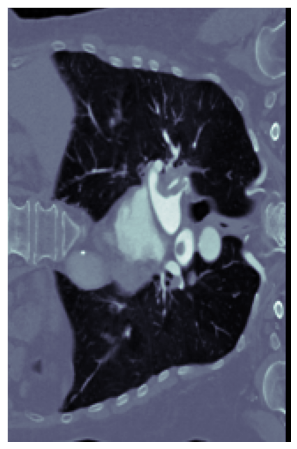

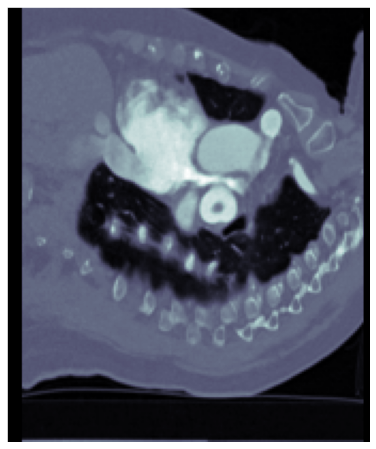

In [29]:
file1 = "/home/adwaye/Documents/abstracts and papers/PNAS/figures/g_truth_0.png"

file2 = "/home/adwaye/Documents/abstracts and papers/PNAS/figures/g_truth_2.png"


im1 = cv2.imread(file1,0)
im2 = cv2.imread(file2,0)

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(im1,cmap='bone')
ax.set_xticks([])
ax.set_yticks([])
output_folder = "/home/adwaye/Documents/abstracts and papers/PNAS/figures"
fig.savefig(os.path.join(output_folder,"g_truth_yslice.png"),transparent=True,bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(im2,cmap='bone')
ax.set_xticks([])
ax.set_yticks([])
output_folder = "/home/adwaye/Documents/abstracts and papers/PNAS/figures"
fig.savefig(os.path.join(output_folder,"g_truth_xslice.png"),transparent=True,bbox_inches='tight')

In [21]:
im1